# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

The ToTensor transformation is essential for converting images into a format that PyTorch can work with(tensors).

The Normalize transformation is critical for standardizing the input data, which can lead to faster convergence during training. The mean and standard deviation values used should be calculated based on the dataset we are working with.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 87340077.95it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24561170.69it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31539807.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10942291.08it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders

The dataloader_args dictionary is used to configure the DataLoader. Using a larger batch size when CUDA is available can help utilize the GPU more efficiently.

The shuffle=True argument in dataloader_args ensures that the data is shuffled at the beginning of each epoch, which can help improve model generalization.

num_workers is set to 4 to enable parallel data loading, which can speed up the data loading process.

pin_memory=True allows for faster data transfer to the GPU by pinning memory on the host (CPU) side.

The DataLoader is responsible for loading the data in batches and applying any specified transformations. It provides an iterable over the dataset for easy integration with training and testing loops.

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


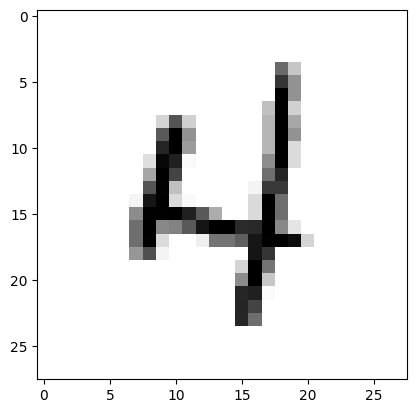

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)


print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

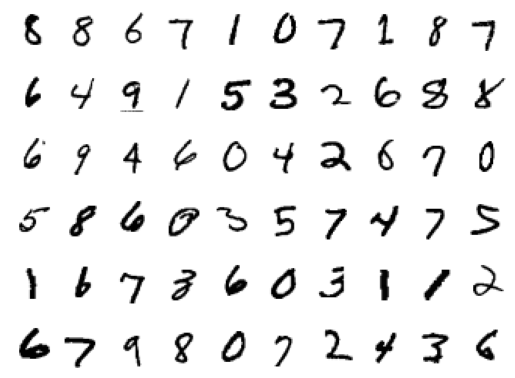

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.1635424941778183 Batch_id=468 Accuracy=82.37: 100%|██████████| 469/469 [00:19<00:00, 23.99it/s]



Test set: Average loss: 0.7634, Accuracy: 7465/10000 (74.65%)

EPOCH: 1


Loss=0.06585651636123657 Batch_id=468 Accuracy=97.44: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]



Test set: Average loss: 0.3571, Accuracy: 8911/10000 (89.11%)

EPOCH: 2


Loss=0.03831309452652931 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]



Test set: Average loss: 0.3204, Accuracy: 9035/10000 (90.35%)

EPOCH: 3


Loss=0.110047847032547 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:24<00:00, 19.45it/s]



Test set: Average loss: 0.1693, Accuracy: 9478/10000 (94.78%)

EPOCH: 4


Loss=0.005647835787385702 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]



Test set: Average loss: 0.0620, Accuracy: 9823/10000 (98.23%)

EPOCH: 5


Loss=0.0428166426718235 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:18<00:00, 24.69it/s]



Test set: Average loss: 0.0588, Accuracy: 9826/10000 (98.26%)

EPOCH: 6


Loss=0.03210824355483055 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:17<00:00, 27.05it/s]



Test set: Average loss: 0.0581, Accuracy: 9818/10000 (98.18%)

EPOCH: 7


Loss=0.05591896176338196 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 28.33it/s]



Test set: Average loss: 0.0584, Accuracy: 9809/10000 (98.09%)

EPOCH: 8


Loss=0.03596740961074829 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:16<00:00, 27.90it/s]



Test set: Average loss: 0.0483, Accuracy: 9845/10000 (98.45%)

EPOCH: 9


Loss=0.015971696004271507 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]



Test set: Average loss: 0.0434, Accuracy: 9863/10000 (98.63%)

EPOCH: 10


Loss=0.011760354973375797 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]



Test set: Average loss: 0.0795, Accuracy: 9739/10000 (97.39%)

EPOCH: 11


Loss=0.007012616842985153 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]



Test set: Average loss: 0.0636, Accuracy: 9794/10000 (97.94%)

EPOCH: 12


Loss=0.06475276499986649 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]



Test set: Average loss: 0.0581, Accuracy: 9815/10000 (98.15%)

EPOCH: 13


Loss=0.01203173864632845 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]



Test set: Average loss: 0.0523, Accuracy: 9836/10000 (98.36%)

EPOCH: 14


Loss=0.006376457866281271 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]



Test set: Average loss: 0.0594, Accuracy: 9804/10000 (98.04%)

EPOCH: 15


Loss=0.008310037665069103 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:17<00:00, 27.42it/s]



Test set: Average loss: 0.0477, Accuracy: 9841/10000 (98.41%)

EPOCH: 16


Loss=0.026795849204063416 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]



Test set: Average loss: 0.0368, Accuracy: 9878/10000 (98.78%)

EPOCH: 17


Loss=0.034365780651569366 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]



Test set: Average loss: 0.0441, Accuracy: 9864/10000 (98.64%)

EPOCH: 18


Loss=0.01877010427415371 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]



Test set: Average loss: 0.0461, Accuracy: 9859/10000 (98.59%)

EPOCH: 19


Loss=0.002242183079943061 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss: 0.0391, Accuracy: 9887/10000 (98.87%)



Text(0.5, 1.0, 'Test Accuracy')

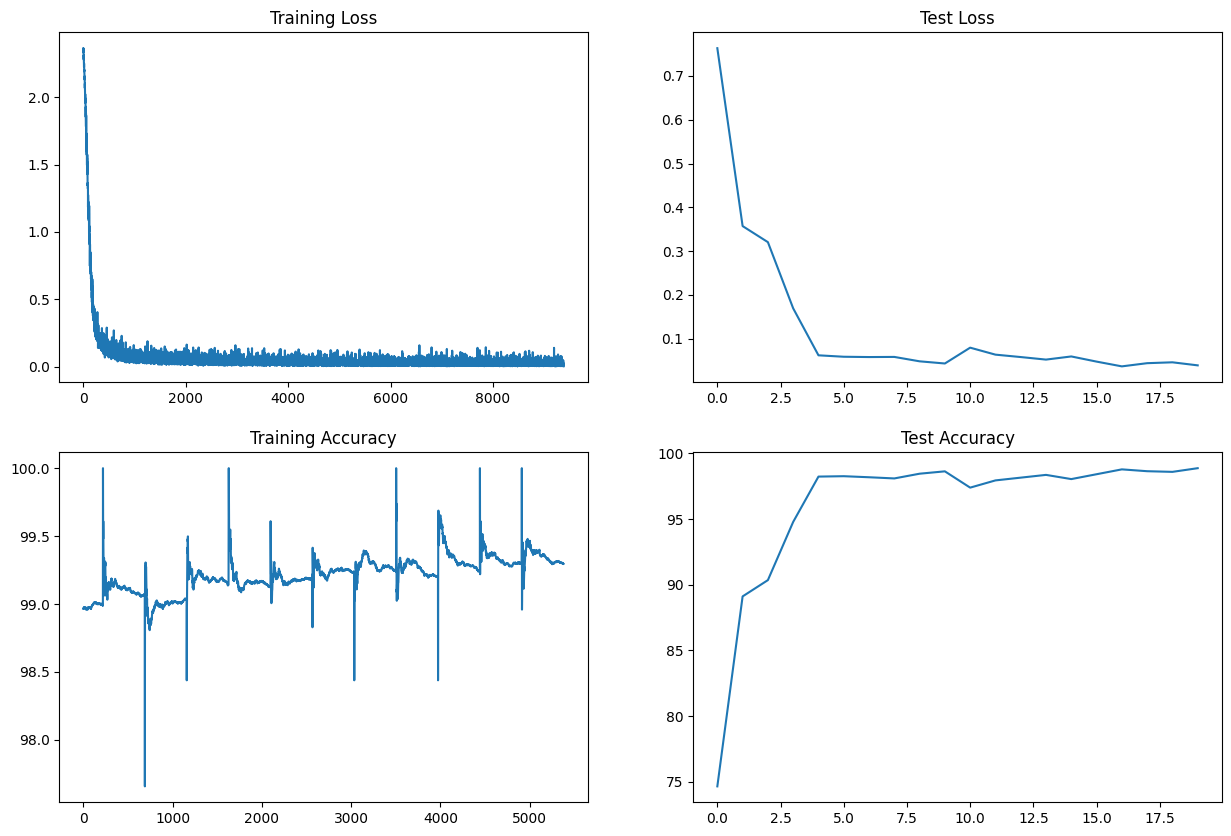

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Summary

## Regularization
Purpose: Implements regularization techniques to prevent overfitting and improve the generalization of the model.

Key Components:
nn.Dropout(0.25): A dropout layer with a probability of 0.25 is applied after the first and second convolution blocks. This randomly zeroes some of the features, which helps in reducing overfitting.

## Global Average Pooling
Purpose: Reduces the spatial dimensions of the feature maps to 1x1, effectively summarizing the features extracted by the convolutional layers.

Key Components:
nn.AvgPool2d(kernel_size=5): A global average pooling layer with a kernel size of 5 is applied after the final convolution block. This reduces the spatial dimensions to 1x1, which is suitable for classification tasks.

## Increasing Capacity
Purpose: Enhances the model's ability to learn complex features by increasing the number of channels in the final convolutional layers.

Key Changes:
Output Block: The number of output channels in the second-last convolutional layer is increased from 20 to 32. This increase in capacity allows the model to learn more complex features, which can improve its performance on classification tasks.

**After these three steps i observed below statistics.

Result:

Parameters: 12k

Best Train Accuracy: 99.30

Best Test Accuracy: 98.9

Analysis:
The model still showing over-fitting, possibly DropOut is not working as expected! Wait yes! We don't know which layer is causing over-fitting. Adding it to a specific layer wasn't a great idea.
Quite Possibly we need to add more capacity, especially at the end.
Closer analysis of MNIST can also reveal that just at RF of 5x5 we start to see patterns forming.**